Accelerating VQEs with quantum natural gradient
===============================================

::: {.meta}
:property=\"og:description\": Accelerating variational quantum
eigensolvers using quantum natural gradients in PennyLane.
:property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets/qng_example.png>
:::

::: {.related}
tutorial\_vqe A brief overview of VQE
tutorial\_quantum\_natural\_gradient Quantum natural gradient
:::

*Authors: Maggie Li, Lana Bozanic, Sukin Sim --- Posted: 06 November
2020. Last updated: 29 August 2023.*

This tutorial showcases how one can apply quantum natural gradients
(QNG) to accelerate the optimization step of the Variational Quantum
Eigensolver (VQE) algorithm. We will implement two small examples:
estimating the ground state energy of a single-qubit VQE problem, which
we can visualize using the Bloch sphere, and the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to
the
`QNG tutorial </demos/tutorial_quantum_natural_gradient>`{.interpreted-text
role="doc"} and `VQE tutorial </demos/tutorial_vqe>`{.interpreted-text
role="doc"} for overviews of quantum natural gradient and the
variational quantum eigensolver algorithm, respectively. Let\'s get
started!

Single-qubit VQE example
------------------------

The first step is to import the required libraries and packages:


In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
from src.superop import superoperator
from src.hsip import HSIP
from src.hsmt import hsmt

In [3]:
from setup_env import setup_environment

setup_environment()

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z.$

We define the device:


In [4]:
dev = qml.device("default.qubit", wires=1)

For the variational ansatz, we use two single-qubit rotations, which the
user may recognize from a previous
`tutorial </demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"} on qubit rotations.


In [5]:
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)

init_params = pnp.array([3.97507603, 3.00854038], requires_grad=True)

We then define our cost function which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric
tensor. This tensor is a crucial component for optimizing with quantum
natural gradients.


(<Figure size 500x200 with 1 Axes>, <Axes: >)


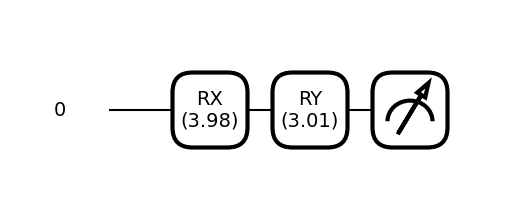

In [6]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

print(qml.draw_mpl(cost_fn, decimals=2)(init_params))

In [7]:
mt_fn = qml.metric_tensor(cost_fn, approx="block-diag")
tensor = mt_fn(init_params)
tensor

tensor([[0.25      , 0.        ],
        [0.        , 0.11299722]], requires_grad=True)

To analyze the performance of quantum natural gradient on VQE
calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients)
and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two
optimizers.


We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}.$ We use a step size of 0.01.


In [8]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

First, we carry out the VQE optimization using the standard gradient
descent method.


We then repeat the process for the optimizer employing quantum natural
gradients:


In [9]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params, metric_tensor_fn=mt_fn)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585 Ha
Number of iterations =  117


### QNG with Superop

(<Figure size 500x300 with 1 Axes>, <Axes: >)


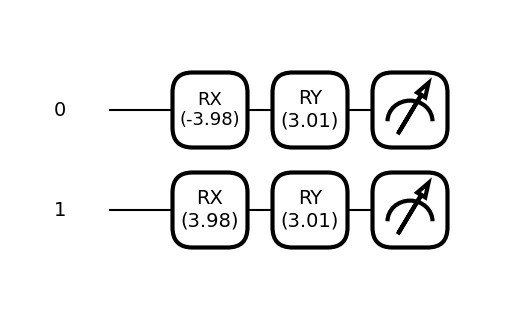

In [10]:
dev_super = qml.device("default.qubit", wires=2)

@qml.qnode(dev_super)
@superoperator()
def qnode_superop(params):
    circuit(params)
    return qml.state()


print(qml.draw_mpl(qnode_superop, decimals=2)(init_params))

In [11]:
meas = HSIP(H, [0])  # Hilbert-Schmidt inner product

def cost_superop(params):
    sv = qnode_superop(params)
    return meas(sv)

In [12]:
hsmt_fn = hsmt(qnode_superop)
metric_tensor = hsmt_fn(init_params)
metric_tensor.real

tensor([[2.50000000e-01, 1.28417717e-18],
        [1.28417717e-18, 1.12997219e-01]], requires_grad=True)

In [13]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qngd_supop_param_history = [params]
qngd_supop_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(
        cost_superop, params.real, metric_tensor_fn=hsmt_fn
    )
    qngd_supop_param_history.append(params)
    qngd_supop_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_superop(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585 Ha
Number of iterations =  117


Visualizing the results
=======================

For single-qubit examples, we can visualize the optimization process in
several ways.

For example, we can track the energy history:


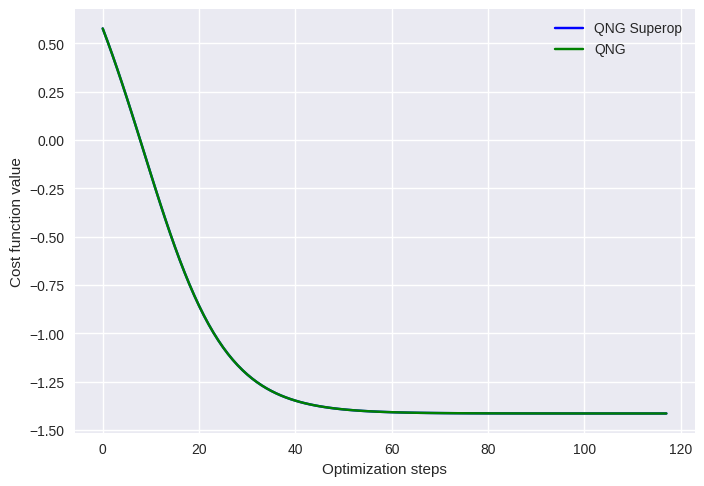

In [14]:
plt.style.use("seaborn-v0_8")
plt.plot(qngd_supop_cost_history, "b", label="QNG Superop")
plt.plot(qngd_cost_history, "g", label="QNG")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a
contour plot. Energies at different grid points have been pre-computed,
and they can be downloaded by clicking
`here<../_static/demonstration_assets/vqe_qng/param_landscape.npy>`{.interpreted-text
role="download"}.


## Single Qubit noisy

(<Figure size 600x200 with 1 Axes>, <Axes: >)


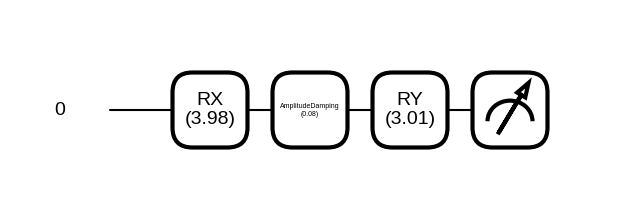

In [15]:
def noisy_circuit(params):
    qml.RX(params[0], wires=0)
    qml.AmplitudeDamping(0.08, wires=0)
    qml.RY(params[1], wires=0)

dev_noisy = qml.device("default.mixed", wires=1)
@qml.qnode(dev_noisy, diff_method="parameter-shift")
def noisy_cost_fn(params):
    noisy_circuit(params)
    return qml.expval(H)

print(qml.draw_mpl(noisy_cost_fn, decimals=2)(init_params))

In [16]:
noisy_mt_fn = qml.metric_tensor(noisy_cost_fn, approx="block-diag")
noisy_tensor = noisy_mt_fn(init_params)
noisy_tensor

array([[0.25      , 0.        ],
       [0.        , 0.12395744]])

In [17]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(noisy_cost_fn, params, metric_tensor_fn=noisy_mt_fn)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = noisy_cost_fn(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.41931199 Ha,  Convergence parameter = 0.04300576 Ha
Iteration = 20,  Energy = -0.42301597 Ha,  Convergence parameter = 0.04394230 Ha
Iteration = 40,  Energy = -1.03461083 Ha,  Convergence parameter = 0.01523665 Ha
Iteration = 60,  Energy = -1.16703714 Ha,  Convergence parameter = 0.00224163 Ha
Iteration = 80,  Energy = -1.18524022 Ha,  Convergence parameter = 0.00029122 Ha
Iteration = 100,  Energy = -1.18759062 Ha,  Convergence parameter = 0.00003751 Ha
Iteration = 120,  Energy = -1.18789397 Ha,  Convergence parameter = 0.00000486 Ha

Final value of the energy = -1.18793044 Ha
Number of iterations =  136


(<Figure size 600x300 with 1 Axes>, <Axes: >)


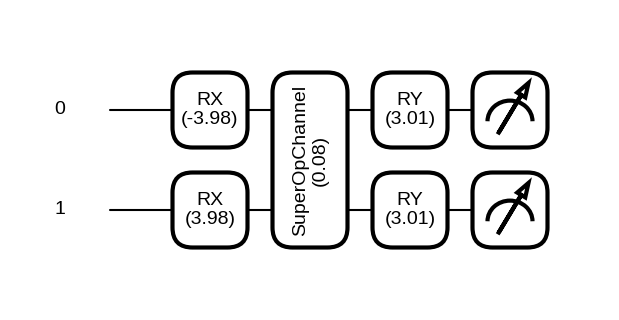

In [18]:
@qml.qnode(dev_super)
@superoperator()
def noisy_qnode_superop(params):
    noisy_circuit(params)
    return qml.state()


print(qml.draw_mpl(noisy_qnode_superop, decimals=2)(init_params))

In [19]:
def noisy_cost_superop(params):
    sv = noisy_qnode_superop(params)
    return meas(sv)

In [20]:
noisy_hsmt_fn = hsmt(noisy_qnode_superop)
metric_tensor = noisy_hsmt_fn(init_params)
metric_tensor.real

tensor([[ 2.19916595e-01, -1.59307965e-18],
        [-1.59307965e-18,  7.25001624e-02]], requires_grad=True)

In [21]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params

qngd_supop_param_history = [params]
qngd_supop_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(
        noisy_cost_superop, params.real, metric_tensor_fn=noisy_hsmt_fn
    )
    qngd_supop_param_history.append(params)
    qngd_supop_cost_history.append(prev_energy)

    # Compute energy
    energy = noisy_cost_superop(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.39628855 Ha,  Convergence parameter = 0.06602920 Ha
Iteration = 20,  Energy = -0.89164210 Ha,  Convergence parameter = 0.03458820 Ha
Iteration = 40,  Energy = -1.15926820 Ha,  Convergence parameter = 0.00362472 Ha
Iteration = 60,  Energy = -1.18528809 Ha,  Convergence parameter = 0.00033439 Ha
Iteration = 80,  Energy = -1.18769094 Ha,  Convergence parameter = 0.00003113 Ha
Iteration = 100,  Energy = -1.18791581 Ha,  Convergence parameter = 0.00000294 Ha

Final value of the energy = -1.18793210 Ha
Number of iterations =  110


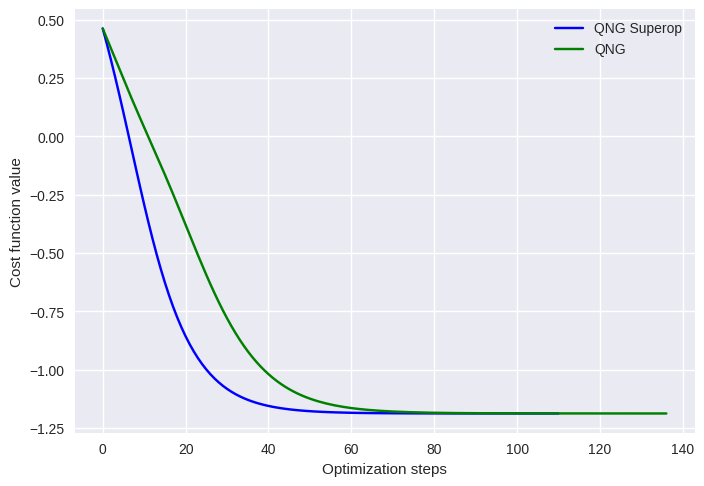

In [22]:
plt.style.use("seaborn-v0_8")
plt.plot(qngd_supop_cost_history, "b", label="QNG Superop")
plt.plot(qngd_cost_history, "g", label="QNG")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Here, the blue regions indicate states with lower energies, and the red
regions indicate states with higher energies. We can see that the
`QNGOptimizer` takes a more direct route to the minimum in larger
strides compared to the path taken by the `GradientDescentOptimizer`.

Lastly, we can visualize the same optimization paths on the Bloch sphere
using routines from [QuTiP](http://qutip.org/). The result should look
like the following:

![](/_static/demonstration_assets/vqe_qng/opt_paths_bloch.png){.align-center
width="50.0%"}

where again the black markers and line indicate the path taken by the
`QNGOptimizer`, and the green markers and line indicate the path taken
by the `GradientDescentOptimizer`. Using this visualization method, we
can clearly see how the path using the `QNGOptimizer` tightly \"hugs\"
the curvature of the Bloch sphere and takes the shorter path.

Hydrogen VQE Example
------------------------

In [4]:
dataset = qml.data.load('qchem',molname="H2", bondlength=0.7)[0]
hamiltonian, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
hamiltonian_coeffs, hamiltonian_ops = hamiltonian.terms()
hf_state = pnp.array([1, 1, 0, 0], requires_grad=False)

print("Number of qubits = ", qubits)

Number of qubits =  4


(<Figure size 1000x500 with 1 Axes>, <Axes: >)


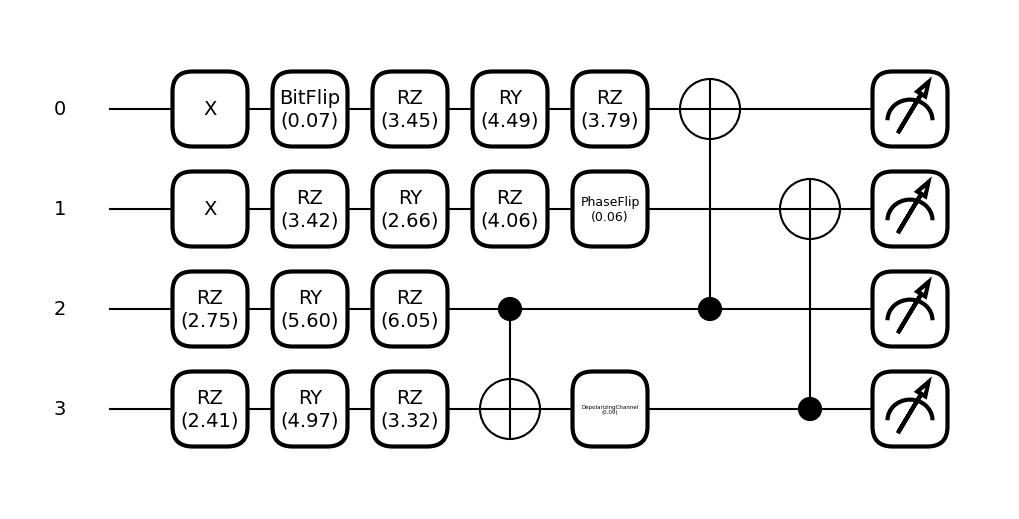

In [9]:
dev = qml.device("default.mixed", wires=qubits)
hf_state = pnp.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    for i, val in enumerate(hf_state):
        if val:
            qml.X(i)
    qml.BitFlip(0.07, wires=0)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.PhaseFlip(0.06, wires=1)
    qml.CNOT(wires=[2, 3])
    qml.DepolarizingChannel(0.09, wires=3)
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

@qml.qnode(dev, diff_method="parameter-shift")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

np.random.seed(0)
init_params = pnp.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
print(qml.draw_mpl(cost, decimals=2)(init_params))

In [10]:
noisy_mt_fn = qml.metric_tensor(cost, approx="block-diag")
noisy_tensor = noisy_mt_fn(init_params)
noisy_tensor.shape

(12, 12)

In [11]:
exact_value = dataset.fci_energy
exact_value

-1.1361895496530567

In [12]:
import time 

max_iterations = 40
step_size = 0.1
conv_tol = 1e-06

hamiltonian = qml.Hamiltonian(pnp.array(hamiltonian_coeffs, requires_grad=False), hamiltonian_ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []


start = time.time()
for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params, metric_tensor_fn=noisy_mt_fn)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break

end = time.time()
print(f"\nDuration:{end-start:.4f}")
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.07030466 Ha
Iteration = 4,  Energy = -0.25145234 Ha
Iteration = 8,  Energy = -0.33449952 Ha
Iteration = 12,  Energy = -0.37678190 Ha
Iteration = 16,  Energy = -0.40275800 Ha
Iteration = 20,  Energy = -0.42317270 Ha
Iteration = 24,  Energy = -0.44429422 Ha
Iteration = 28,  Energy = -0.47217083 Ha
Iteration = 32,  Energy = -0.51568513 Ha
Iteration = 36,  Energy = -0.58834949 Ha

Duration:33.0852
Final convergence parameter = 0.02977633 Ha
Number of iterations =  39
Final value of the ground-state energy = -0.66970118 Ha
Accuracy with respect to the FCI energy: 0.46648837 Ha (292.72285427 kcal/mol)

Final circuit parameters = 
 [3.44829694 6.22418287 3.78727399 3.42360201 1.42031592 4.0582724
 2.74944154 6.24884164 6.03481288 2.40923412 5.24430253 3.32314479]


(<Figure size 1300x900 with 1 Axes>, <Axes: >)


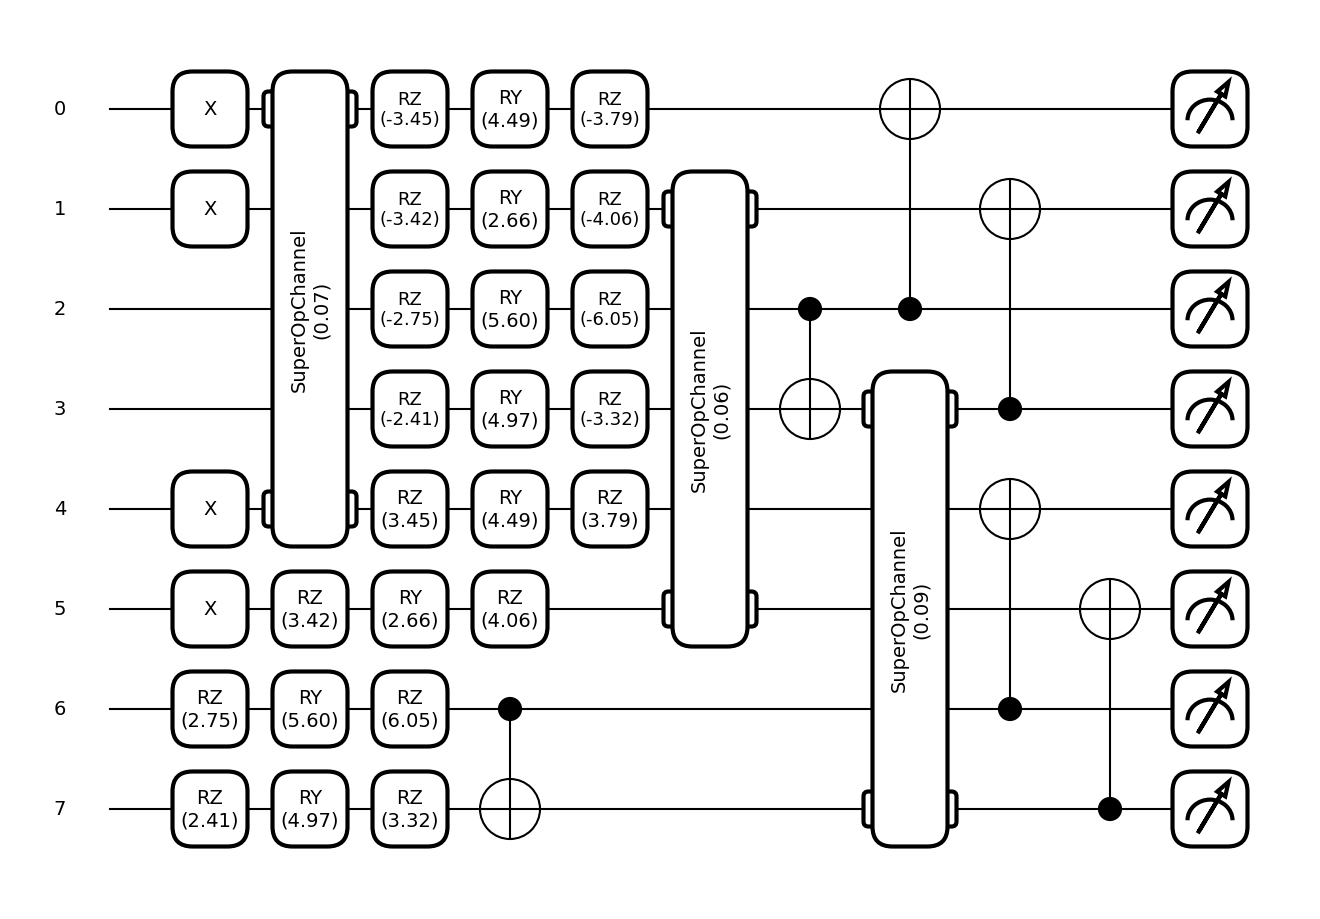

In [16]:
dev_super = qml.device("default.qubit", wires=2*qubits)

@qml.qnode(dev_super)
@superoperator()
def noisy_qnode_superop(params):
    ansatz(params)
    return qml.state()

meas = HSIP(hamiltonian, range(qubits))  # Hilbert-Schmidt inner product

def noisy_cost_superop(params):
    sv = noisy_qnode_superop(params)
    return meas(sv)

print(qml.draw_mpl(noisy_qnode_superop, decimals=2)(init_params))

In [19]:
noisy_hsmt_fn = hsmt(noisy_qnode_superop)
metric_tensor = noisy_hsmt_fn(init_params)
metric_tensor.shape

(12, 12)

In [20]:
opt = qml.QNGOptimizer(stepsize=step_size)

params = init_params
prev_energy = noisy_cost_superop(params)
qngd_supop_cost = []

start = time.time()
for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(
        noisy_cost_superop, params.real, metric_tensor_fn=noisy_hsmt_fn
    )
    qngd_supop_cost.append(prev_energy)

    # Compute energy
    energy = noisy_cost_superop(params)

    # Calculate difference between new and old energies
    conv = pnp.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break
        
end = time.time()
print(f"\nDuration:{end-start:.4f}")
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.10505664 Ha
Iteration = 4,  Energy = -0.31615097 Ha
Iteration = 8,  Energy = -0.38567883 Ha
Iteration = 12,  Energy = -0.42066899 Ha
Iteration = 16,  Energy = -0.45255959 Ha
Iteration = 20,  Energy = -0.50305101 Ha
Iteration = 24,  Energy = -0.60544252 Ha
Iteration = 28,  Energy = -0.78428700 Ha
Iteration = 32,  Energy = -0.95421659 Ha
Iteration = 36,  Energy = -1.02310932 Ha

Duration:67.0536
Final convergence parameter = 0.00259697 Ha
Number of iterations =  39
Final value of the ground-state energy = -1.03598848 Ha
Accuracy with respect to the FCI energy: 0.10020107 Ha (62.87647240 kcal/mol)

Final circuit parameters = 
 [  2.95040333+1.11489486e-03j   6.28115071+2.36098922e-21j
   3.78727399-4.38850369e-15j  -1.39740929+3.69663284e-03j
   0.1573437 +1.34721086e-10j   4.0582724 -1.00185705e-16j
   1.55560085+9.32774694e-03j   6.09721897+2.60213594e-08j
   6.28318531-6.21663247e-17j 102.87020571-3.64285577e-03j
   6.22554537-1.39019873e-05j   3.31721927+1.

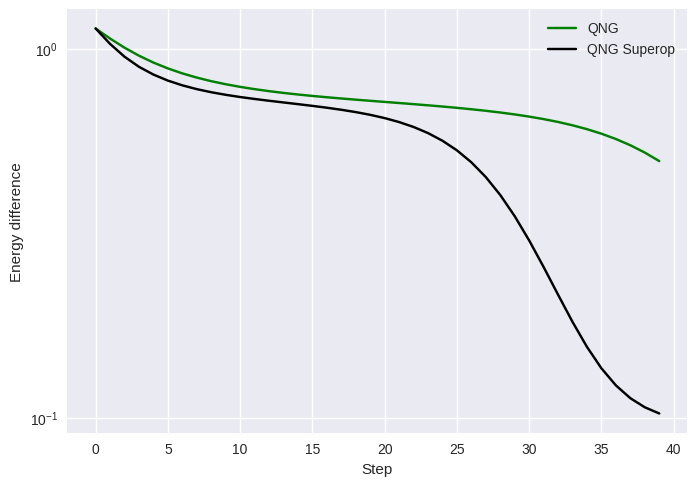

In [21]:
plt.style.use("seaborn-v0_8")
plt.plot(np.array(qngd_cost) - exact_value, "g", label="QNG")
plt.plot(np.array(qngd_supop_cost) - exact_value, "k", label="QNG Superop")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()